In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
onlyfiles = [f for f in listdir('../input/global-wheat-detection/test/') if isfile(join('../input/global-wheat-detection/test/', f))]

test_df = pd.DataFrame(onlyfiles,columns=['image_id'])

In [4]:
transform =  A.Compose([
        ToTensorV2(p=1.0)
    ])


def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, transforms):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread('../input/global-wheat-detection/test/'+image_id, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        sample = {
            'image': image,
        }
        sample = self.transforms(**sample)
        image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [6]:
test_dataset = WheatTestDataset(test_df,transform)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,pretrained_backbone=False)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [8]:
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.box_predictor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [10]:
model.load_state_dict(torch.load('../input/faster-rcnn-pretrained-weights/fasterrcnn_resnet50_fpn.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [11]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [12]:
detection_threshold = 0.5
results = []
testdf_psuedo = []
for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        for box in boxes:
            result = {
                'image_id': 'nvnn'+image_id,
                'source': 'nvnn',
                'x': box[0],
                'y': box[1],
                'w': box[2],
                'h': box[3]
            }
            testdf_psuedo.append(result)

In [13]:
test_df_pseudo = pd.DataFrame(testdf_psuedo, columns=['image_id', 'source', 'x', 'y', 'w', 'h'])
test_df_pseudo.head()

,image_id,source,x,y,w,h
0,nvnn2fd875eaa.jpg,nvnn,391,788,74,92
1,nvnn2fd875eaa.jpg,nvnn,453,473,86,149
2,nvnn2fd875eaa.jpg,nvnn,108,576,134,83
3,nvnn2fd875eaa.jpg,nvnn,733,880,89,92
4,nvnn2fd875eaa.jpg,nvnn,0,906,99,83


In [14]:
import cv2
img = cv2.imread("../input/global-wheat-detection/test/348a992bb.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

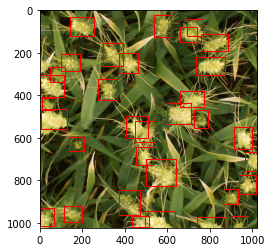

In [15]:
fig,ax = plt.subplots(1)
ax.imshow(img)
for x,y,width,height in test_df_pseudo[test_df_pseudo['image_id'] == "nvnn348a992bb.jpg"][['x','y','w','h']].values:
    rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

In [16]:
train_df = pd.read_csv("../input/global-wheat-detection/train.csv")
train_df.drop(['width','height'],axis=1,inplace=True)

In [17]:
train_df['x'] = train_df['bbox'].apply(lambda x: int(float(x[1:-1].split(',')[0])))
train_df['y'] = train_df['bbox'].apply(lambda x: int(float(x[1:-1].split(',')[1])))
train_df['w'] = train_df['bbox'].apply(lambda x: int(float(x[1:-1].split(',')[2])))
train_df['h'] = train_df['bbox'].apply(lambda x: int(float(x[1:-1].split(',')[3])))

In [18]:
train_df.drop('bbox',axis=1,inplace=True)

In [19]:
train_df = pd.concat([train_df,test_df_pseudo],axis=0)
train_df.reset_index(drop=True,inplace=True)

In [20]:
train_df

,image_id,source,x,y,w,h
0,b6ab77fd7,usask_1,834,222,56,36
1,b6ab77fd7,usask_1,226,548,130,58
2,b6ab77fd7,usask_1,377,504,74,160
3,b6ab77fd7,usask_1,834,95,109,107
4,b6ab77fd7,usask_1,26,144,124,117
...,...,...,...,...,...,...
147992,nvnnf5a1f0358.jpg,nvnn,532,3,89,97
147993,nvnnf5a1f0358.jpg,nvnn,548,259,120,116
147994,nvnnf5a1f0358.jpg,nvnn,89,817,65,62
147995,nvnnf5a1f0358.jpg,nvnn,829,567,142,207


In [21]:
transform =  A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [22]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, transforms):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        if 'nvnn' in image_id:
            image_id = image_id[4:]
            image = cv2.imread('../input/global-wheat-detection/test/'+image_id, cv2.IMREAD_COLOR)
        else:
            image = cv2.imread('../input/global-wheat-detection/train/'+image_id+'.jpg', cv2.IMREAD_COLOR)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((records.shape[0],), dtype=torch.int64)       
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['iscrowd'] = iscrowd
        target['area'] = area
        target['image_id'] = torch.tensor([index])

        sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        sample = self.transforms(**sample)
        image = sample['image']

        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [23]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [24]:
train_dataset = WheatDataset(train_df,transform)

In [25]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [26]:
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [27]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0001)

In [28]:
loss_hist = Averager()

num_epochs = 30

In [29]:
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.5146602392196655
Iteration #100 loss: 0.46384987235069275
Iteration #150 loss: 0.5628236532211304
Iteration #200 loss: 0.6281267404556274
Epoch #0 loss: 0.4728332937888379
Iteration #250 loss: 0.5605291128158569
Iteration #300 loss: 0.3291403353214264
Iteration #350 loss: 0.6478418111801147
Iteration #400 loss: 0.3746063709259033
Epoch #1 loss: 0.4614874556098344
Iteration #450 loss: 0.5404443740844727
Iteration #500 loss: 0.49203670024871826
Iteration #550 loss: 0.43273159861564636
Iteration #600 loss: 0.39904820919036865
Epoch #2 loss: 0.4515783515460086
Iteration #650 loss: 0.6065716743469238
Iteration #700 loss: 0.5712214708328247
Iteration #750 loss: 0.4998234808444977
Iteration #800 loss: 0.5146110653877258
Epoch #3 loss: 0.4474878221187951
Iteration #850 loss: 0.4846964478492737
Iteration #900 loss: 0.5037418603897095
Iteration #950 loss: 0.40600666403770447
Iteration #1000 loss: 0.36057859659194946
Iteration #1050 loss: 0.37976062297821045
Epoch #4 loss: 0

In [30]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn2nd.pt')

In [31]:
model.eval()
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [32]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df['image_id'] = test_df['image_id'].apply(lambda x: x.split(".")[0])
test_df.head()

,image_id,PredictionString
0,2fd875eaa,0.9999 0 728 85 114 0.9999 462 345 122 101 0.9...
1,cc3532ff6,1.0000 688 463 143 93 1.0000 766 814 168 167 0...
2,51b3e36ab,1.0000 686 604 338 129 1.0000 824 436 200 162 ...
3,53f253011,1.0000 147 305 133 112 1.0000 445 150 120 132 ...
4,cb8d261a3,1.0000 31 548 163 98 0.9999 747 694 90 96 0.99...


In [33]:
test_df.to_csv('submission.csv', index=False)